In [1]:
import random
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader

from polara import get_movielens_data
from polara.preprocessing.dataframes import reindex

from neural_dice_v2 import SquaredActivation, ValueNetwork, NeuralDice
from policy import RandomPolicy, PopularRandomPolicy
from data import MovieLensBasicMDP, transform_indices, CartPoleMDP

%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
RANDOM_SEED = 12
DEVICE = torch.device('cpu')
BATCH_SIZE = 2
NUM_SAMPLES = 1024
NUM_ITER = 10000
EVAL_ITER = 100

ZETA_POS = False # squared output of zeta(s,a)                  (used in GenDICE, BestDice)
ZERO_REWARD = True # whether include the reward in loss or not (used in MQL, BestDICE)
NORM_REGULARIZER = 0.0 # use lambda or not                      (used in GenDICE, GradientDICE, BestDICE)
PRIMAL_REGULARIZER = 0.0 # alpha_Q                              (used in GenDICE, GradientDICE)
DUAL_REGULARIZER = 1.0 # alpha_zeta                             (used in DualDICE, BestDICE)

NU_LR = 0.003
ZETA_LR = 0.003
GAMMA = 0.99

In [3]:
def custom_collate(data_list):
    first_state = []
    current_state = []
    current_action = []
    next_state = []
    rewards = []
    step_num = []

    for fs, cs, ca, ns, rw, sn in data_list:
        first_state.append(fs)
        current_state.append(cs)
        current_action.append(ca)
        next_state.append(ns)
        rewards.append(rw)
        step_num.append(sn)

    return (
        torch.concat(first_state, dim=0),
        torch.concat(current_state, dim=0),
        torch.concat(current_action, dim=0),
        torch.concat(next_state, dim=0),
        torch.concat(rewards, dim=0),
        torch.concat(step_num, dim=0)
    )

loader_generator = torch.Generator()
loader_generator.manual_seed(RANDOM_SEED)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed+worker_id)

dataset = CartPoleMDP(
    ds_path="/home/hdilab/amgimranov/Dice-RL/cartpole_ds.npy",
    num_samples=NUM_SAMPLES
)

loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    prefetch_factor=4,
    pin_memory=True,
    collate_fn=custom_collate,
    persistent_workers=True,
    worker_init_fn=seed_worker,
    generator=loader_generator
)

In [4]:
from cartpole import RandomPolicy

policy = RandomPolicy(
    device=DEVICE,
    name='RandomPolicy',
)

In [5]:
nu = ValueNetwork(
    num_layers=2,
    state_dim=4,
    action_dim=2,
    hidden_dim=64,
    output_activation=None,
    seed=RANDOM_SEED
)
nu = nu.to(DEVICE)

zeta = ValueNetwork(
    num_layers=2,
    state_dim=4,
    action_dim=2,
    hidden_dim=64,
    output_activation=SquaredActivation if ZETA_POS else None,
    seed=RANDOM_SEED+1
)
zeta = zeta.to(DEVICE)

nu_optimizer = torch.optim.Adam(list(nu.parameters()), lr=NU_LR)
zeta_optimizer = torch.optim.Adam(list(zeta.parameters()), lr=ZETA_LR)

dice = NeuralDice(
    nu_network=nu,
    zeta_network=zeta,
    nu_lr=NU_LR,
    zeta_lr=ZETA_LR,
    lambda_lr=NU_LR,
    num_actions=2,
    gamma=GAMMA,
    zero_reward=ZERO_REWARD,
    f_exponent=1.5,
    primal_form=False,
    num_action_samples=None, # number of action samples used in Q expectation
    primal_regularizer=PRIMAL_REGULARIZER,
    dual_regularizer=DUAL_REGULARIZER,
    norm_regularizer=NORM_REGULARIZER,
    nu_regularizer=0.0, # nu network regularizer
    zeta_regularizer=0.0, # zeta network regularizer
    weight_by_gamma=False, # weight loss by gamma**step_num
    device=DEVICE
)

In [9]:
def estimate_policy(data: MovieLensBasicMDP, print_zeta=False):
    values = []
    for batch in data.iterate_dataset(batch_size=100):
        batch = [b.to(DEVICE) for b in batch]
        states, actions, rewards = batch

        values.append(
            dice.estimate_average_reward(
                states=states,
                actions=actions,
                rewards=rewards,
                print_zeta=print_zeta
            )
        )
        print_zeta=False

    return np.mean(values)

In [11]:
def plot_info(nu_losses, zeta_losses, values):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.plot(nu_losses)
    plt.title('nu loss')

    plt.subplot(1, 3, 2)
    plt.plot(zeta_losses)
    plt.title('zeta loss')

    plt.subplot(1, 3, 3)
    plt.plot(values)
    plt.title('values')

    plt.show()

Value on iteration 700: 0.11315813887582044


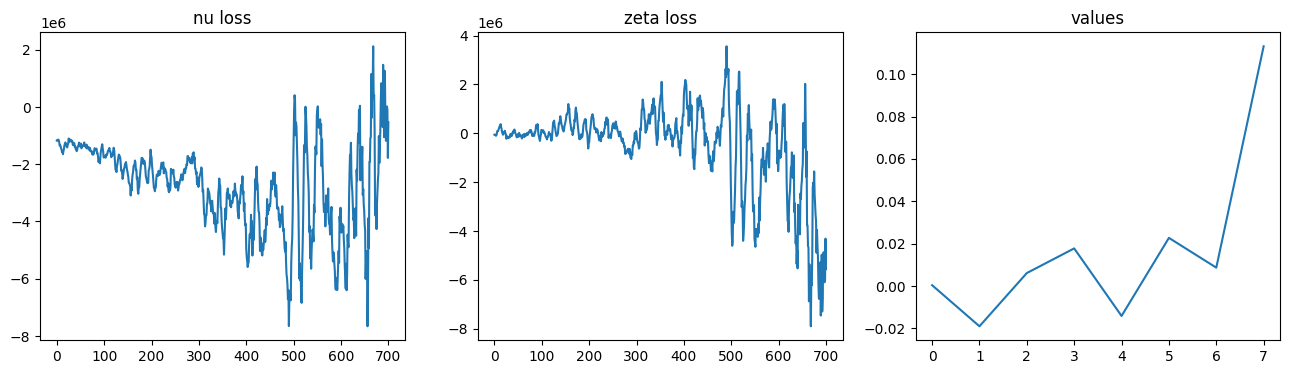

  7%|▋         | 711/10000 [00:12<02:49, 54.87it/s]


KeyboardInterrupt: 

In [12]:
from tqdm import tqdm
from IPython.display import clear_output

nu_losses = []
zeta_losses = []
lambda_losses = []
values = []

for i, batch in enumerate(tqdm(loader, total=NUM_ITER)):
    if i >= NUM_ITER:
        break

    batch = [b.to(DEVICE) for b in batch]

    nu_loss, zeta_loss, lambda_loss = dice.train_batch(batch=batch, policy=policy)
    nu_losses.append(nu_loss)
    zeta_losses.append(zeta_loss)
    lambda_losses.append(lambda_loss)

    if i % EVAL_ITER  == 0 or i == (NUM_ITER - 1):
        value = estimate_policy(data=dataset, print_zeta=True)
        values.append(value)
        clear_output()
        print(f'Value on iteration {i}: {value}')
        plot_info(nu_losses, zeta_losses, values)

* проверить правильно ли написан CartPole
* еще раз посмотреть знаки + в целом логику лосса (можно переписать через одно число)
* проверить opt.step() и backward()
* логгировать градиенты
* зафиксировать nu и посмотреть сходимость по zeta. она должна выучиваться, если ее нет, то что-то не так с градиентами
* посмотреть выходы zeta
* zero_reward
* понять что мы получаем p или p_hat
* понять что мы хотим получить

In [ ]:
values[-10:]

[9.474991798400879,
 1.8831393122673035,
 12.640719920396805,
 -5.971481144428253,
 -0.5734628140926361,
 8.923543870449066,
 7.580229938030243,
 9.9191335439682,
 9.990345925092697,
 6.00968211889267]